# Image Segmentation with $k$-means & Gaussian Mixture Models

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.data import camera
plt.style.use('jpg.mplstyle')

## Introduction

My research is focused on detecting diffuse galaxies in optical imaging data, and I have naturally become quite interested in image processing. Therefore, I decided to find an image processing application for some of the statistical techniques we have learned this semester. My inspiration for this notebook came from reading the Wikipedia article on [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation), which discusses the use of clustering methods such as $k$-means for segmenting images. While putting this notebook together, I heavily referenced Jake VanderPlas's [Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) and Chapter 9 of [Pattern Recognition and Machine Learning](http://www.springer.com/us/book/9780387310732) by Christopher Bishop. I additionally referred to [Digital Image Processing](http://www.imageprocessingplace.com/DIP-3E/dip3e_main_page.htm) for background information on the relevant image processing techniques.

## Image Segmentation

Image segmentation is the process of partitioning an image into its constituent parts or objects. In astronomy, this is typically done by <a href="https://en.wikipedia.org/wiki/Thresholding_(image_processing)">image thresholding</a>, the simplest image segmentation method, and is one of the first steps in all source extraction algorithms. Automating image segmentation turns out to be one of the most difficult problems in digital image processing, and astronomy is no exception; indeed, large-scale sky surveys like SDSS and [HSC-SPP](http://hsc.mtk.nao.ac.jp/ssp/) are plagued by the so-called blending of objects, a problem that will only be exacerbated by deeper and wider surveys such as LSST. 

As a *very* simple example of image segmentation, let's use thresholding to segment the classic cameraman image from the [scikit-image](http://scikit-image.org) dataset:

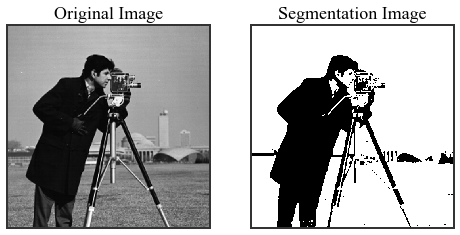

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8),
                       subplot_kw=dict(xticks=[], yticks=[]))
cam = camera()
ax[0].imshow(cam, cmap='gray')
ax[0].set_title('Original Image')
thresh = cam > 0.5*np.median(cam)
ax[1].imshow(thresh, cmap='gray')
ax[1].set_title('Segmentation Image');

Here, I've thresholded the image at 50% of the median pixel value. The resulting segmentation image is binary, with pixels greater than the threshold set to 1 and pixels less than the threshold set to 0. While this is an overly simple example, it is already clear how this might be a useful first step for object detection.

## Segmentation in color with $k$-means 

As we discussed this semester, $k$-means is a very intuitive algorithm, which searches for $k$ clusters within an unlabeled multi-dimensional dataset. The $k$-means algorithm is a simple example of the Expectation-Maximization (E-M) method. Given some $N$-dimensional dataset, the algorithm proceeds as follows:

- **Initialization:** Pick the number of clusters $k$, and randomly set their centers
- **Expectation:** Assign each data point to the cluster that minimizes some distance measure
- **Maximization:** Reset the centers of the clusters to the mean position of their members
- **Iterate:** Repeat steps 2 and 3 until convergence

So, what does this have to do with image segmentation? A color image can be thought of as a 3-dimensional dataset, where each pixel in the image is a point in red-green-blue color space, and we can use $k$-means to find clustering of points in this space. 

As an illustration of this idea, let's look at an image I took while visiting the [Nikko National Park](https://en.wikipedia.org/wiki/Nikkō_National_Park) in Japan: 

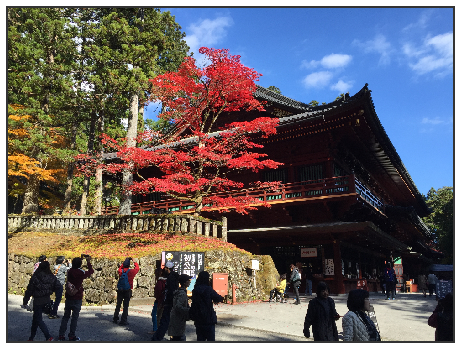

In [3]:
nikko = rescale(mpimg.imread('nikko.jpg'), 0.3)
data = nikko.reshape(nikko.shape[0]*nikko.shape[1], 3)
plt.figure(figsize=(8, 8))
plt.gca().set(xticks=[], yticks=[])
plt.imshow(nikko);

In [4]:
nikko.shape

(734, 979, 3)

This image has ${\sim}7\times10^5$ pixels, which can be viewed as our *samples*, and 3 color dimensions, which can be viewed as our $features$. 

Let's view the pixels of this image in 3-dimensional color space. I'll randomly select a subset of 8,000 pixels, so my old computer doesn't explode:

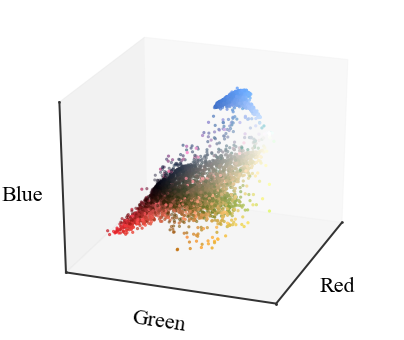

In [5]:
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
idx = np.random.choice(np.arange(data.shape[0]), size=8000, replace=False)
r, g, b = data[idx].T
ax.scatter(r, g, b, c=data[idx], marker='.')
ax.set(xlabel='Red', ylabel='Green', zlabel='Blue', 
       xticks=[], yticks=[], zticks=[])
ax.view_init(25, 20)

In the above figure, the color of the points directly corresponds to the colors in the image. One interesting property we can already notice is that the blue data points appear to be fairly isolated from the other colors, suggesting that we might be able to use $k$-means to isolate the sky in our image.

For efficiency, I'll write a function to plot up the results in the following section:

In [6]:
def plot_palette(image, data, color_arr, title):  
    idx = np.random.choice(np.arange(data.shape[0]), size=10000, replace=False)
    r, g, b = data[idx].T
    grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0)
    plt.figure(figsize=(15, 7))
    im_ax = plt.subplot(grid[0:2, 0:2], xticks=[], yticks=[])
    rg_ax = plt.subplot(grid[0, 2], xticks=[])
    rg_ax.set_title('Color-Space Projection')
    rb_ax = plt.subplot(grid[1, 2])  
    im_ax.imshow(image)
    for y_dat, ax, ylabel in zip([g, b], [rg_ax, rb_ax], ['Green', 'Blue']):
        ax.set_xlabel('Red', fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.scatter(r, y_dat, c=color_arr[idx], marker='.')
    im_ax.set_title(title, fontsize=23);

Here's what this function plots for the original image, which has 256$^3$ possible colors:

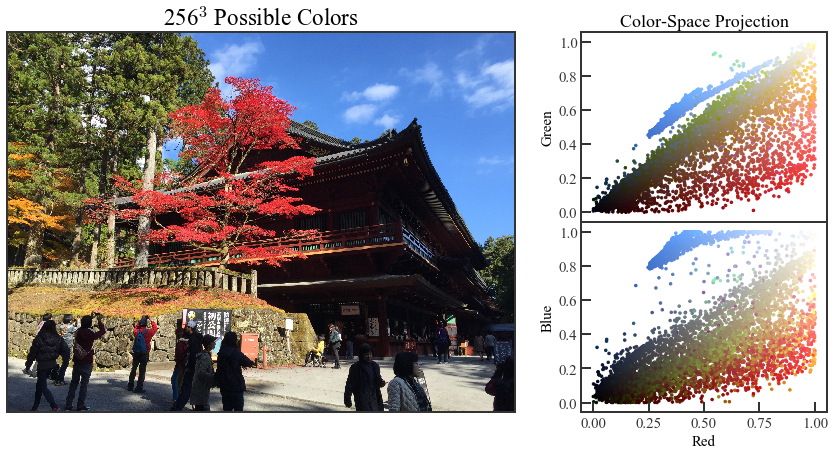

In [7]:
plot_palette(nikko, data, data, '256$^3$ Possible Colors')

The left panel shows the image, and the right panel shows the projection of the pixels in red-blue and red-green color space. 

Even for this small image, the dataset is quite large. Fortunately, [scikit-learn](http://scikit-learn.org) has implemented the mini batch $k$-means (`MiniBatchKMeans`), which as the name suggests, uses subsets of the data to find the $k$-means clusters much more efficiently than the standard method. Let's find the $k$-means clusters of the Nikko image for $k$ = 2, 4, 8, and 16: 

In [8]:
compressed = {}
k_vals = [2, 4, 8, 16]
for k in k_vals:
    kmeans = MiniBatchKMeans(k)
    kmeans.fit(data)
    compressed[k] = kmeans.cluster_centers_[kmeans.predict(data)]

For each pixel, we now have cluster assignments for each of the $k$ values. Thus, we can segment the image into $k$ = 2, 4, 8, and 16 colors, assigning each pixel the value of its cluster's center. Note that this can also be viewed as [lossy image compression](https://en.wikipedia.org/wiki/Image_compression), since we only need to store the cluster assignments along with $k$ 3-dimensional vectors for the cluster centers. This compression method is often called [vector quantization](https://en.wikipedia.org/wiki/Vector_quantization).

Let's visualize the results for each $k$ value:

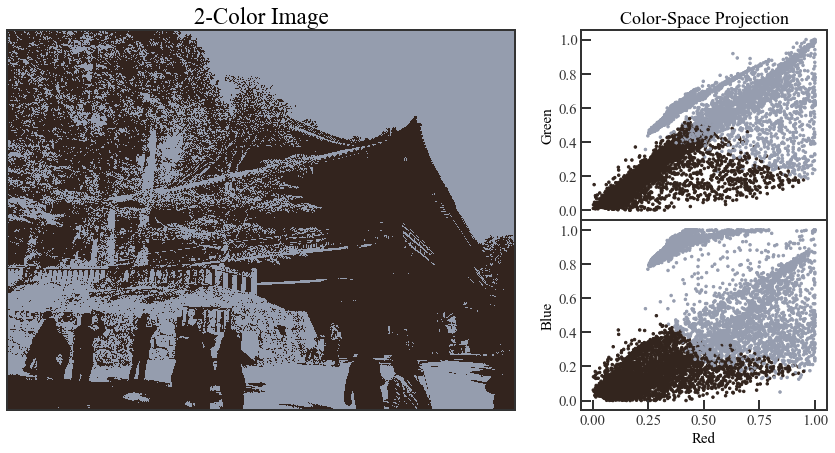

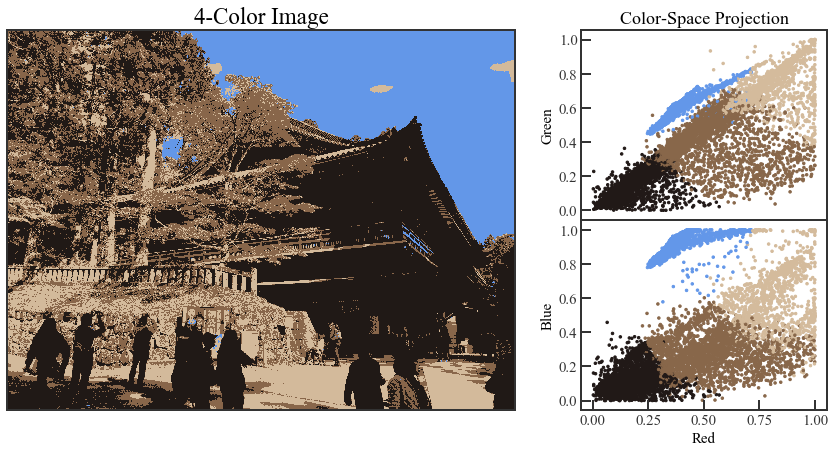

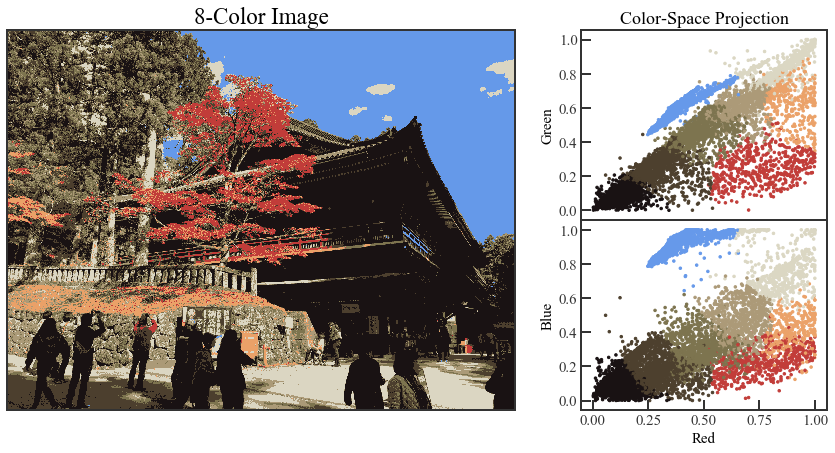

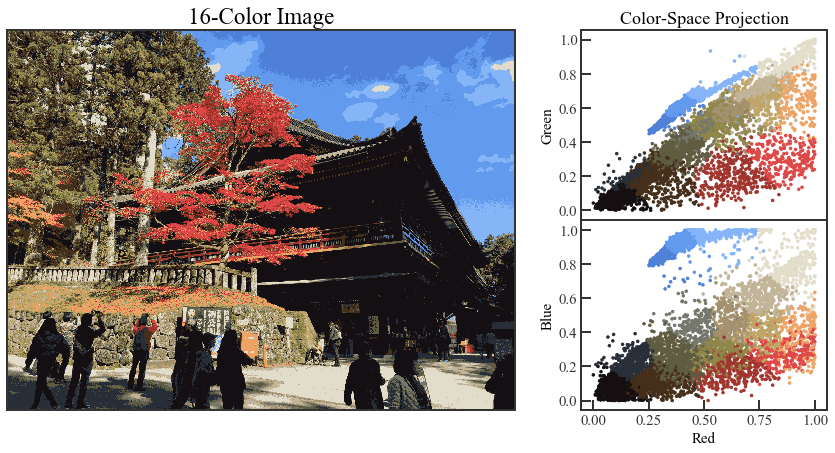

In [9]:
for k in k_vals:
    new_img = compressed[k].reshape(nikko.shape)
    plot_palette(new_img, data, compressed[k], '{}-Color Image'.format(k))

In the panels on the right, the $k$ clusters are clearly visible in each figure. As we noted above, the blue pixels are relatively isolated in color space, and as a result, $k$-means has effectively labeled the sky pixels. The 16-color image looks pretty good, and we've reduced the number of possible colors by a factor of 1 million! In computer graphics, the reduction of the number of distinct colors in an image is known as [color quantization](https://en.wikipedia.org/wiki/Color_quantization).

## Segmentation with Gaussian Mixture Models

While $k$-means is easy to implement and understand, its binary in-or-out cluster assignment doesn't account for uncertainties and is therefore inherently non-probabilistic. Furthermore, standard $k$-means only allows for spherical clusters, which will yield poor cluster assignments for data with significant non-spherical structure. 

Gaussian Mixture Models (GMMs) address both of these shortcomings by modeling each cluster as a multidimensional Gaussian distribution, resulting in a generative probabilistic model for the data that is composed of a mixture of Gaussians. The E-M algorithm for GMMs is very similar to $k$-means; in fact, $k$-means can be viewed as a GMM in the limit of diagonal, equal, and tiny covariances. 

For a quick example of image segmentation with GMMs, I'll use another image I took of a small town near Nikko National Park. While we could certainly carry out this exercise in color, let's work with a black-and-white image for simplicity:

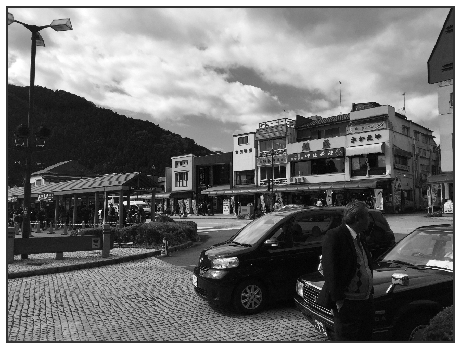

In [10]:
town = rescale(mpimg.imread('town.jpg'), 0.4)
town = rgb2gray(town)
plt.figure(figsize=(8, 8))
plt.gca().set(xticks=[], yticks=[])
plt.imshow(town, cmap='gray');

Again, I'll create a function to plot results:

In [11]:
def plot_seg_image(clf):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    cmap = plt.cm.get_cmap('Spectral', clf.n_components)

    ax[0].imshow(clf.means_[clf.predict(X)].reshape(town.shape), cmap=cmap)
    ax[0].set(xticks=[], yticks=[])
    ax[1].hist(town.flatten(), bins='auto', normed=True, alpha=0.4, color='gray')
    
    xpdf = np.linspace(0, 1, 1000)
    density = np.exp(clf.score_samples(xpdf.reshape(-1, 1)))
    ax[1].plot(xpdf, density, 'k--', zorder=10, lw=2)
    ax[1].set_xlabel('pixel values')

    for i in range(clf.n_components):
        pdf = clf.weights_[i]*stats.norm(
            clf.means_[i, 0], np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
        ax[1].plot(xpdf, pdf, '-', c=cmap(clf.means_[i, 0]), lw=4)
    fig.suptitle('{} Gaussians'.format(clf.n_components), fontsize=22)

I'll use `scikit-learn` to model the pixel intensity values as a mixture of 2, 3, 4, and  5 Gaussians:

In [12]:
X = town.flatten().reshape(-1,1)
n_comps = [2, 3, 4, 5]
clf = {}
for n_comp in n_comps:
    gmm = GaussianMixture(n_comp, covariance_type='full')
    clf[n_comp] = gmm.fit(X)

Similar to the $k$-means example above, we now have labels for every pixel corresponding to one the Gaussians in each of the mixture models. 

Let's visualize the results:

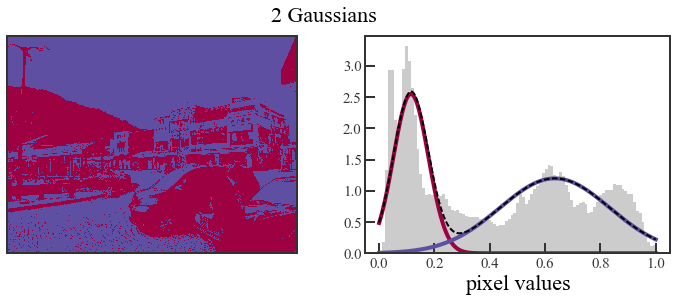

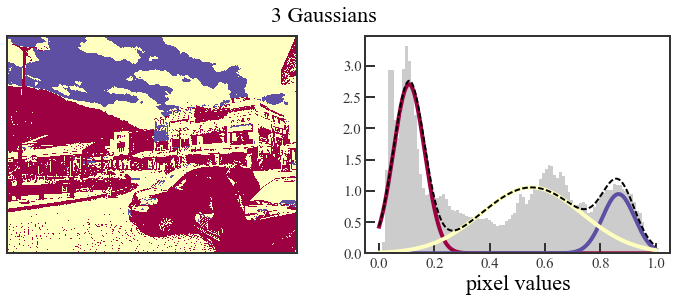

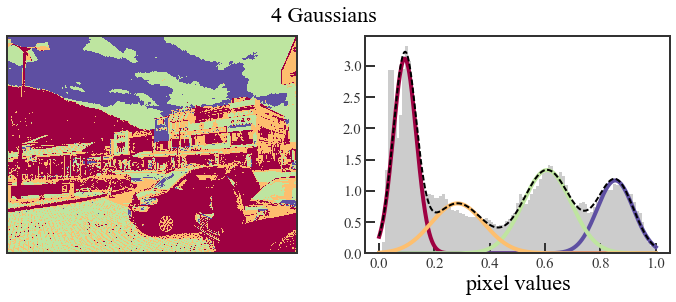

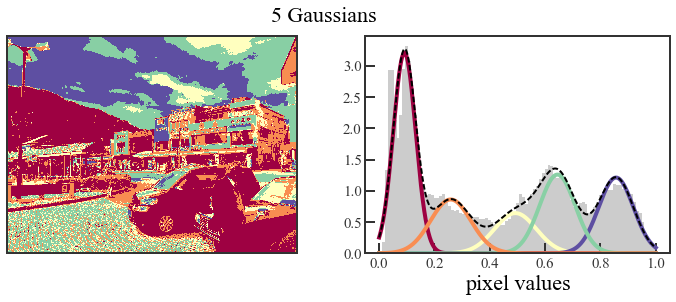

In [13]:
for n_comp in n_comps:    
    plot_seg_image(clf[n_comp])

In each of the figures, the left panel shows the segmented image, and the right panel shows the histogram of pixel values with the best-fit Gaussians overlaid. The colors in the image correspond to the colors of the Gaussians. 